In [1]:
import sys
import yaml

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

sys.path.append('../src')
sys.path.append('../../../utils')

from unet_pretrainer import UnetPretrainer
from isbi_em_dataset import ISBIEMDataset

from eval_utils import evaluate_model, get_top_k_accuracy
from train_utils import Trainer, he_init, get_distribution

/home/kramasamy/.venv/globalenv/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2024-12-18 21:30:11.808317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734537611.825108   16922 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734537611.830384   16922 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 21:30:11.847962: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow

In [2]:
from torchvision.datasets import CIFAR10

# Load config.
with open('../configs/pretrain_config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.4809, std=0.2392)
])

train_dataset = CIFAR10(root='../../../data/cifar_10', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='.../../../data/cifar_10', train=False, download=True, transform=transform)

print(f"Train Dataset: {len(train_dataset)} samples")
print(f"Test Dataset: {len(test_dataset)} samples")

sample_img, label = train_dataset[0]
print(f"Image shape: {sample_img.shape}")
print(f"Label: {label}")

Files already downloaded and verified
Files already downloaded and verified
Train Dataset: 50000 samples
Test Dataset: 10000 samples
Image shape: torch.Size([1, 32, 32])
Label: 6


In [3]:
get_distribution(train_dataset)

(tensor(-0.0002), tensor(1.0000))

In [4]:
# Load model.
torch.cuda.empty_cache()
model = UnetPretrainer(config['num_classes'])
model.to('cuda')
model.apply(he_init)
trainer = Trainer(model, train_dataset, config)
result = trainer.train(print_loss=True)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 2.469737174559613


  5%|▌         | 1/20 [01:40<31:51, 100.59s/it]

Epoch 2/20, Loss: 1.8045835032755015


 10%|█         | 2/20 [03:28<31:32, 105.15s/it]

Epoch 3/20, Loss: 1.5681708029338293


 15%|█▌        | 3/20 [05:57<35:23, 124.92s/it]

Epoch 4/20, Loss: 1.4074187169269639


 20%|██        | 4/20 [08:26<35:49, 134.35s/it]

Epoch 5/20, Loss: 1.2442418397689352


 25%|██▌       | 5/20 [10:55<34:54, 139.64s/it]

Epoch 6/20, Loss: 1.132989870042217


 30%|███       | 6/20 [13:19<32:54, 141.06s/it]

Epoch 7/20, Loss: 1.0604508464433708


 35%|███▌      | 7/20 [15:39<30:32, 140.97s/it]

Epoch 8/20, Loss: 0.9249773256632746


 40%|████      | 8/20 [18:00<28:10, 140.90s/it]

Epoch 9/20, Loss: 0.8639606632748429


 45%|████▌     | 9/20 [20:22<25:55, 141.37s/it]

Epoch 10/20, Loss: 0.8258318426657696


 50%|█████     | 10/20 [22:44<23:33, 141.32s/it]

Epoch 11/20, Loss: 0.7808615693024227


 55%|█████▌    | 11/20 [25:06<21:15, 141.72s/it]

Epoch 12/20, Loss: 0.754497156459458


 60%|██████    | 12/20 [27:34<19:08, 143.62s/it]

Epoch 13/20, Loss: 0.6798693939131133


 65%|██████▌   | 13/20 [30:03<16:56, 145.24s/it]

Epoch 14/20, Loss: 0.6478832765501372


 70%|███████   | 14/20 [32:31<14:36, 146.08s/it]

Epoch 15/20, Loss: 0.650619667403552


 75%|███████▌  | 15/20 [35:02<12:17, 147.45s/it]

Epoch 16/20, Loss: 0.590301516408823


 80%|████████  | 16/20 [37:33<09:54, 148.66s/it]

Epoch 17/20, Loss: 0.5760419213650178


 85%|████████▌ | 17/20 [40:03<07:26, 148.84s/it]

Epoch 18/20, Loss: 0.5640947645416066


 90%|█████████ | 18/20 [42:32<04:58, 149.06s/it]

Epoch 19/20, Loss: 0.5558641425200871


 95%|█████████▌| 19/20 [45:01<02:28, 148.97s/it]

Epoch 20/20, Loss: 0.545198380034797


100%|██████████| 20/20 [47:28<00:00, 142.44s/it]


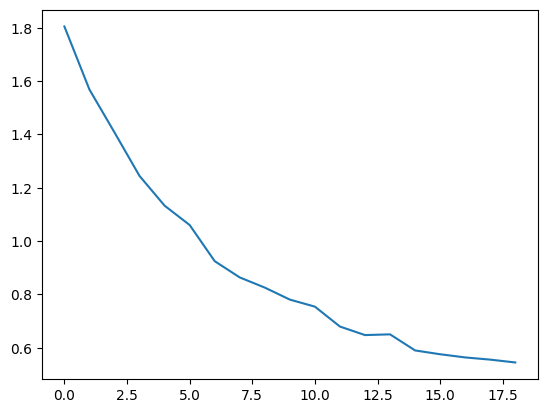

In [5]:
import matplotlib.pyplot as plt

plt.plot(result['loss_history'][1:])

In [6]:
torch.cuda.empty_cache()
train_loader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=512, shuffle=False)
y_pred_train, y_true_train = evaluate_model(model, train_loader)
y_pred_test, y_true_test = evaluate_model(model, test_loader)

In [7]:
print(get_top_k_accuracy(y_pred_train, y_true_train, k = 1))
print(get_top_k_accuracy(y_pred_test, y_true_test, k = 1))


79.13199663162231
73.4499990940094


In [9]:
import pickle as pkl
pkl.dump(result, open('../checkpoints/pretrain_unet_results.pkl', 'wb'))